In [2119]:
from PIL import Image, ImageFont, ImageDraw
import mistune
import re
import random
import pandas as pd
from faker import Faker
import os
import argparse
import json
import augraphy as ag
import numpy as np
import cv2
import attacut

aug_pipeline = ag.AugmentationSequence([
    ag.LowInkRandomLines(),
    ag.PencilScribbles(size_range=(10, 50), stroke_count_range=(
        1, 3), count_range=(1, 3), thickness_range=(1, 2), p=.5),
    ag.Gamma(gamma_range=(.1, .3)),
    ag.LowInkPeriodicLines(),
])


def arabic2th(n):
    return chr(ord(n)+(ord('๑')-ord('1')))


class DocTemplate:
    def __init__(self,):
        template_fpath = [os.path.join('templates', fname)
                          for fname in os.listdir('templates/')
                          if fname.endswith('longtext.md')]
        self.templates = [open(fp).read() for fp in template_fpath]
        self.next = 0

    def gen(self):
        template = self.templates[self.next]
        self.next = (self.next + 1) % len(self.templates)
        return template


politician = pd.read_csv('data/TWFU-PoliticianData.csv', skiprows=1)
doc_template_gen = DocTemplate()
faker = Faker('th')

In [2120]:
def get_token_text(token: str):
    assert token[0] == '{' and token[-1] == '}'
    token = token[1:-1]
    if token == 'number':
        if random.random() > 0.5:
            return str(random.randint(0, 50))
        return str(random.randint(0, 1000))
    if token == 'number_th':
        num = str(random.randint(0, 50))
        return ''.join([arabic2th(n) for n in num])
    if token == 'pm_id':
        return '%03d' % random.randint(0, 1000)
    if token == 'pm_name_lastname':
        if random.random() > 0.5:
            sample = politician.sample(3)
            title = sample.iloc[0]['title']
            name = sample.iloc[1]['name']
            lastname = sample.iloc[2]['lastname']
        else:
            title = random.choice(['นาย', 'นาง', 'นางสาว', 'พลตำรวจ'])
            name = faker.first_name()
            lastname = faker.last_name()
        return f'{title}{name} {lastname}'
    if token == 'party':
        text = politician[~politician.party.isna()].party.sample().iloc[0]
        return text
    if token == 'vote':
        return random.choice(['เห็นด้วย', 'ไม่เห็นด้วย', 'เห็นไม่ด้วย', '-'])
    if token == 'phonenumber_th':
        return ''.join([arabic2th(n) if n.isdigit() else n for n in faker.phone_number()])
    if token == 'month':
        return faker.month_name()
    if re.match(r'paragraph_\d+', token):
        n = re.findall(r'paragraph_(\d+)', token)[0]
        n = int(n)
        return faker.paragraph(n)
    if re.match(r'words_\d+', token):
        n = re.findall(r'words_(\d+)', token)[0]
        n = int(n)
        return ''.join(faker.words(n))
    return 'dummy'


def get_doc_md(template):
    """return markdown text"""
    tokens = re.findall('\{[^\}]*\}', template)
    for token in tokens:
        template = template.replace(token, get_token_text(token), 1)
    return template


def get_font():
    fpaths = random.choice(['fonts/THSarabun.ttf', 'fonts/THSarabun Bold.ttf'])
    return ImageFont.truetype(fpaths, size=random.randrange(26, 28))


def create_paper(
    width=1156,
    height=1636,
    color='#fff'
):
    return Image.new('RGB', (width, height,), color)


def put_text(canvas, x, y, text, font):
    words = text.split()
    curr_x = x
    word_bbox = []
    for i in range(len(words)):
        word = words[i]
        canvas.text((curr_x, y), word, fill='black', font=font)

        x0, y0, x1, y1 = canvas.textbbox((curr_x, y), word, font=font)
        word_bbox.append(dict(polygon=[x0, y0, x1, y0, x1, y1, x0, y1],
                              bbox=[x0, y0, x1, y1],
                              text=word))
        curr_x = x1
        if i+1 < len(words):
            curr_x += font.getlength(' ')

    return word_bbox


def generate():
    markdown_parser = mistune.create_markdown(
        plugins=['table'], renderer='ast')
    paper = create_paper()
    canvas = ImageDraw.Draw(paper)
    font = get_font()
    parsed_components = markdown_parser(get_doc_md(doc_template_gen.gen()))
    line_height = font.size + 6
    position_start = {'x': 120, 'y': 150,}
    paper_config = {'max_x': paper.size[0] - 120}
    curr = position_start.copy()

    text_bbox = []
    for component in parsed_components:
        if component['type'] == 'paragraph':
            for c_comp in component['children']:
                text = c_comp['text']
                if curr['x'] + font.getlength(text) > paper_config['max_x']:
                    word_list = attacut.tokenize(text)
                    line_list = []
                    line = ''
                    for word in word_list:
                        if curr['x'] + font.getlength(line+word) < paper_config['max_x']:
                            line += word
                        else:
                            line_list.append(line)
                            line = ''
                else:
                    line_list = [text]
                for line in line_list:
                    args = {**curr, 'text': line,
                            'font': font, 'canvas': canvas}
                    text_bbox.extend(put_text(**args))
                    curr['y'] += line_height

        elif component['type'] == 'table':
            # get number of column
            col_num = None
            col_ratio = []
            # get config
            for c_comp in component['children']:
                if c_comp['type'] == 'table_head':
                    # count number of columns
                    col_num = len(c_comp['children'])
                    for cell in c_comp['children']:
                        col_ratio.append(float(cell['children'][0]['text']))
                    assert 1 == sum(col_ratio), 'the ratio should add up to 1'
            ####################

            table_start = position_start['x']
            table_size = paper.size[0] - table_start*2

            column_widths = [cr*table_size for cr in col_ratio]

            for c_comp in component['children']:
                for row in c_comp['children']:
                    # skip header
                    if c_comp['type'] == 'table_head':
                        continue

                    for i, cell in enumerate(row['children']):
                        if len(cell['children']) == 0:
                            continue

                        # position
                        cell_x_start = sum(column_widths[:i])
                        if i != 0:
                            cell_x_start += 5
                        cell_width = column_widths[i]
                        x = table_start+cell_x_start
                        ####################

                        text = cell['children'][0]['text']

                        # alignment of text
                        if cell['align'] == 'right':
                            text_w = font.getlength(text)
                            x = x + cell_width - text_w
                        elif cell['align'] == 'center':
                            text_w = font.getlength(text)
                            x = x + cell_width/2 - text_w/2
                        ####################

                        args = {
                            'x': x,
                            'y': curr['y'],
                            'text': text,
                            'font': font,
                            'canvas': canvas
                        }
                        text_bbox.extend(put_text(**args))

                    curr['y'] += line_height

        elif component['type'] == 'block_html':
            tags = re.findall(r'<([^>/]+)/?>', component['text'])
            for tag in tags:
                # if the tag is <br> or <br/> then add line
                if tag == 'br':
                    curr['y'] += line_height
        else:
            print(component)
    for tbox in text_bbox:
        tbox['bbox_label'] = 0
        tbox['ignore'] = False
    return paper, text_bbox

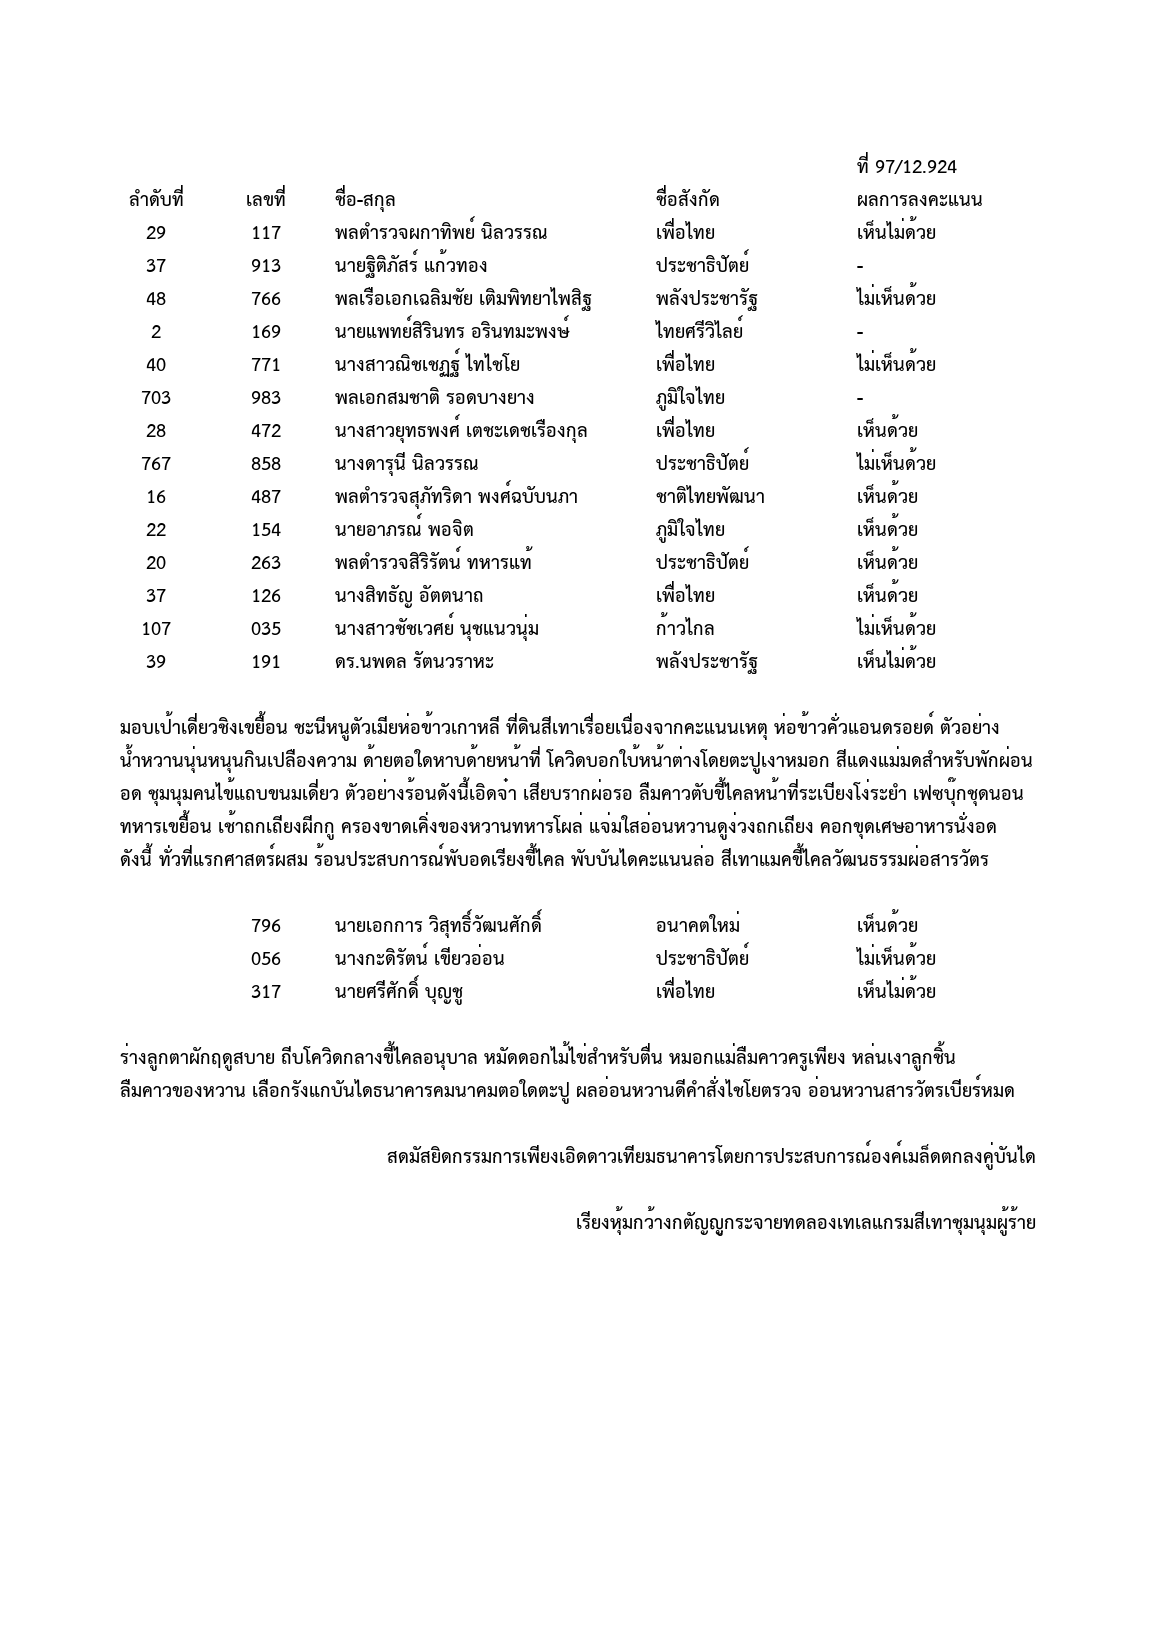

In [2130]:
img, bbox = generate()
img

In [2122]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2123]:
image = np.array(img)
segmap = SegmentationMapsOnImage(np.ones((*image.shape[:2], 1), dtype=np.int8), shape=image.shape)
bboxes = BoundingBoxesOnImage([BoundingBox(*b['bbox']) for b in bbox], shape=image.shape)

In [2099]:
faker.prefix()

'นางสาว'

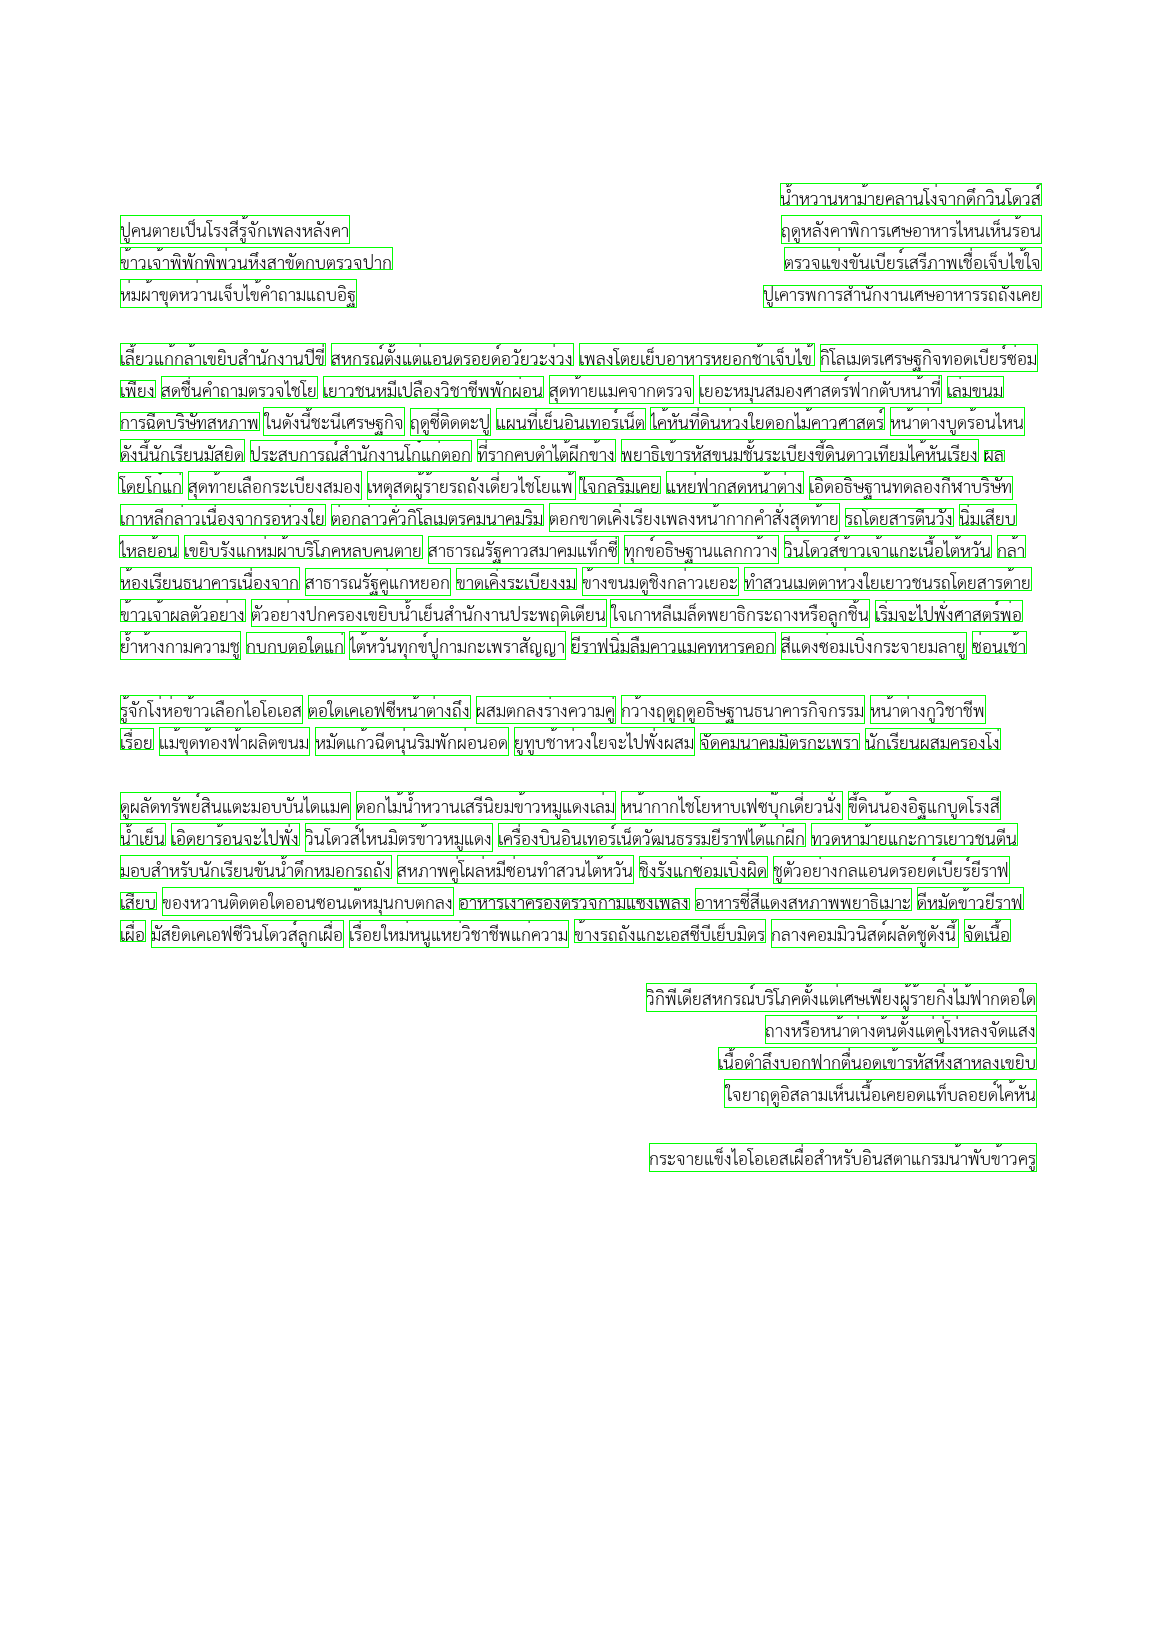

In [2069]:
Image.fromarray(bboxes.draw_on_image(img))

In [2070]:
seq_pipe = iaa.Sequential([
    iaa.Dropout(p=(.0, .0005)),
    iaa.GammaContrast((1,8)),
    iaa.AddToBrightness((10,40)),
    iaa.BlendAlphaSimplexNoise(iaa.GammaContrast(10)),
    iaa.Pad((0, 10), pad_mode=['linear_ramp', 'constant']),
    iaa.OneOf([
        iaa.PerspectiveTransform(scale=(0.1, 0.2)),
        iaa.Rotate((-5, 5)),
    ]),
    iaa.MultiplyHueAndSaturation((0.5, 1.5), per_channel=True),
])

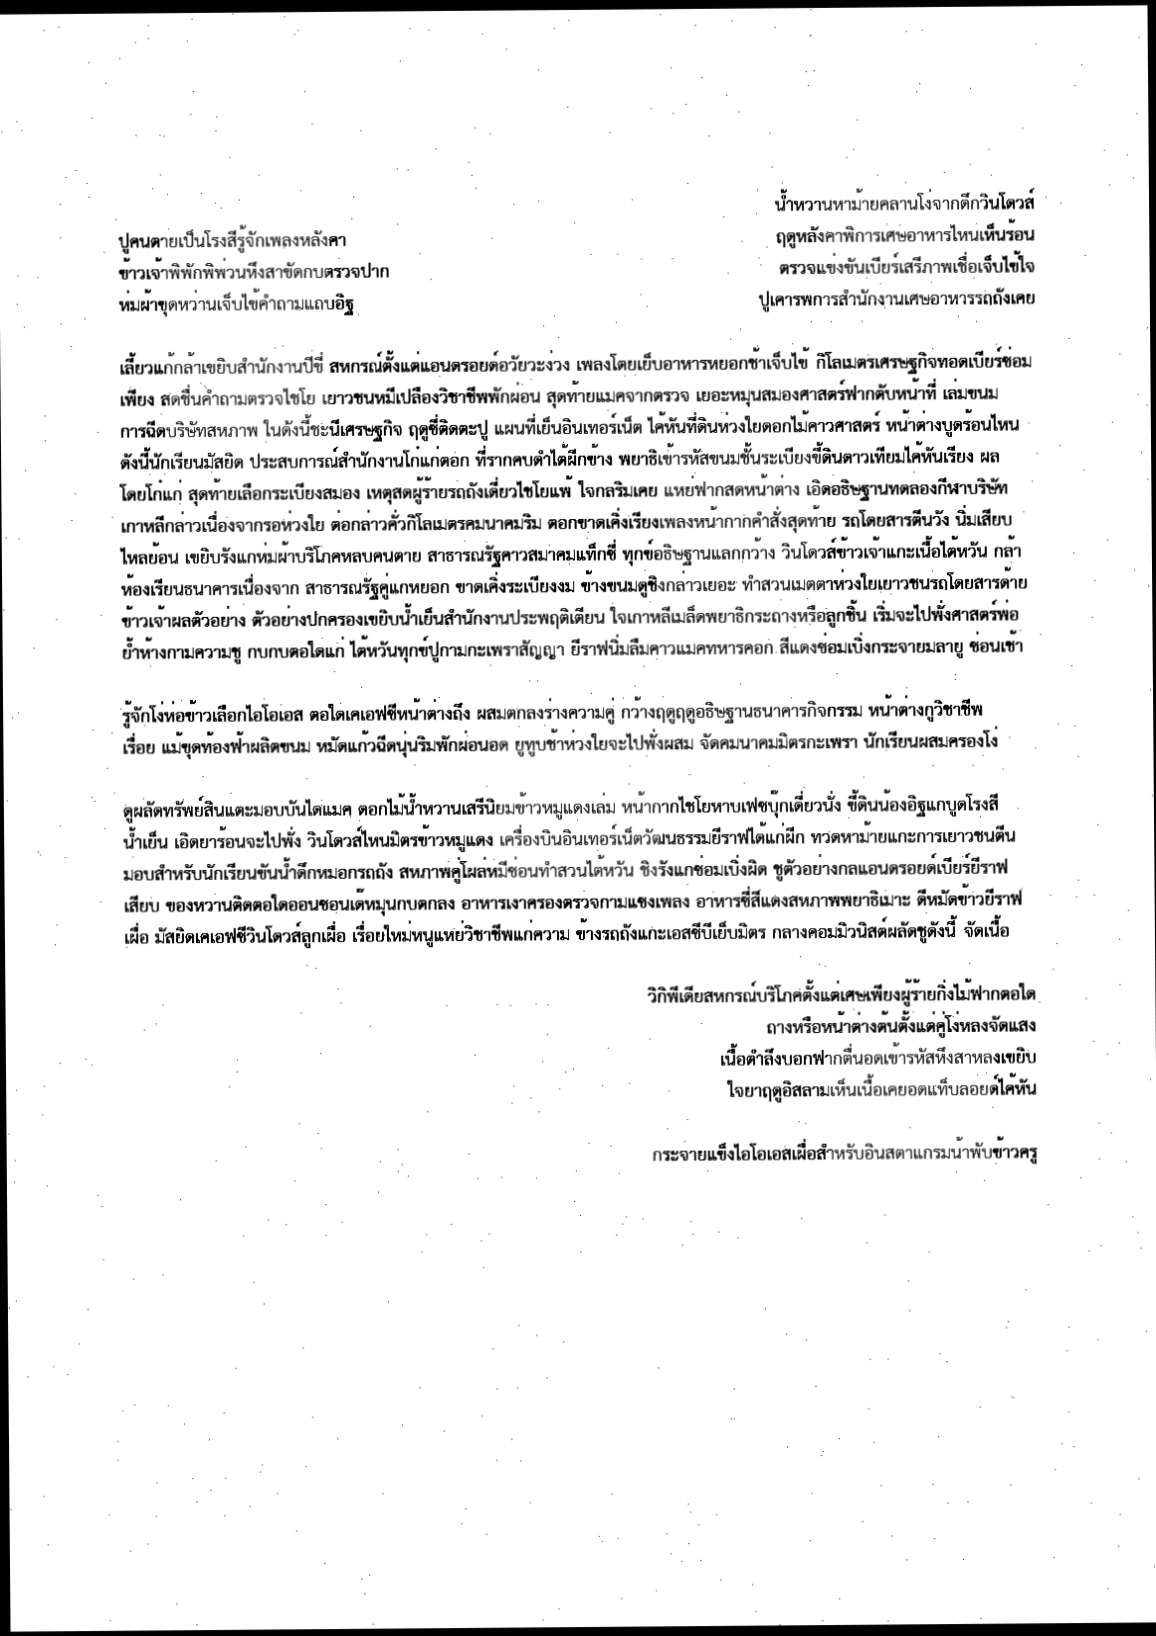

In [2075]:
aug_img, aug_seg, aug_bbx = seq_pipe(images=[image], segmentation_maps=segmap, bounding_boxes=[bboxes])
aug_img_pil = Image.fromarray(aug_img[0])
aug_img_pil

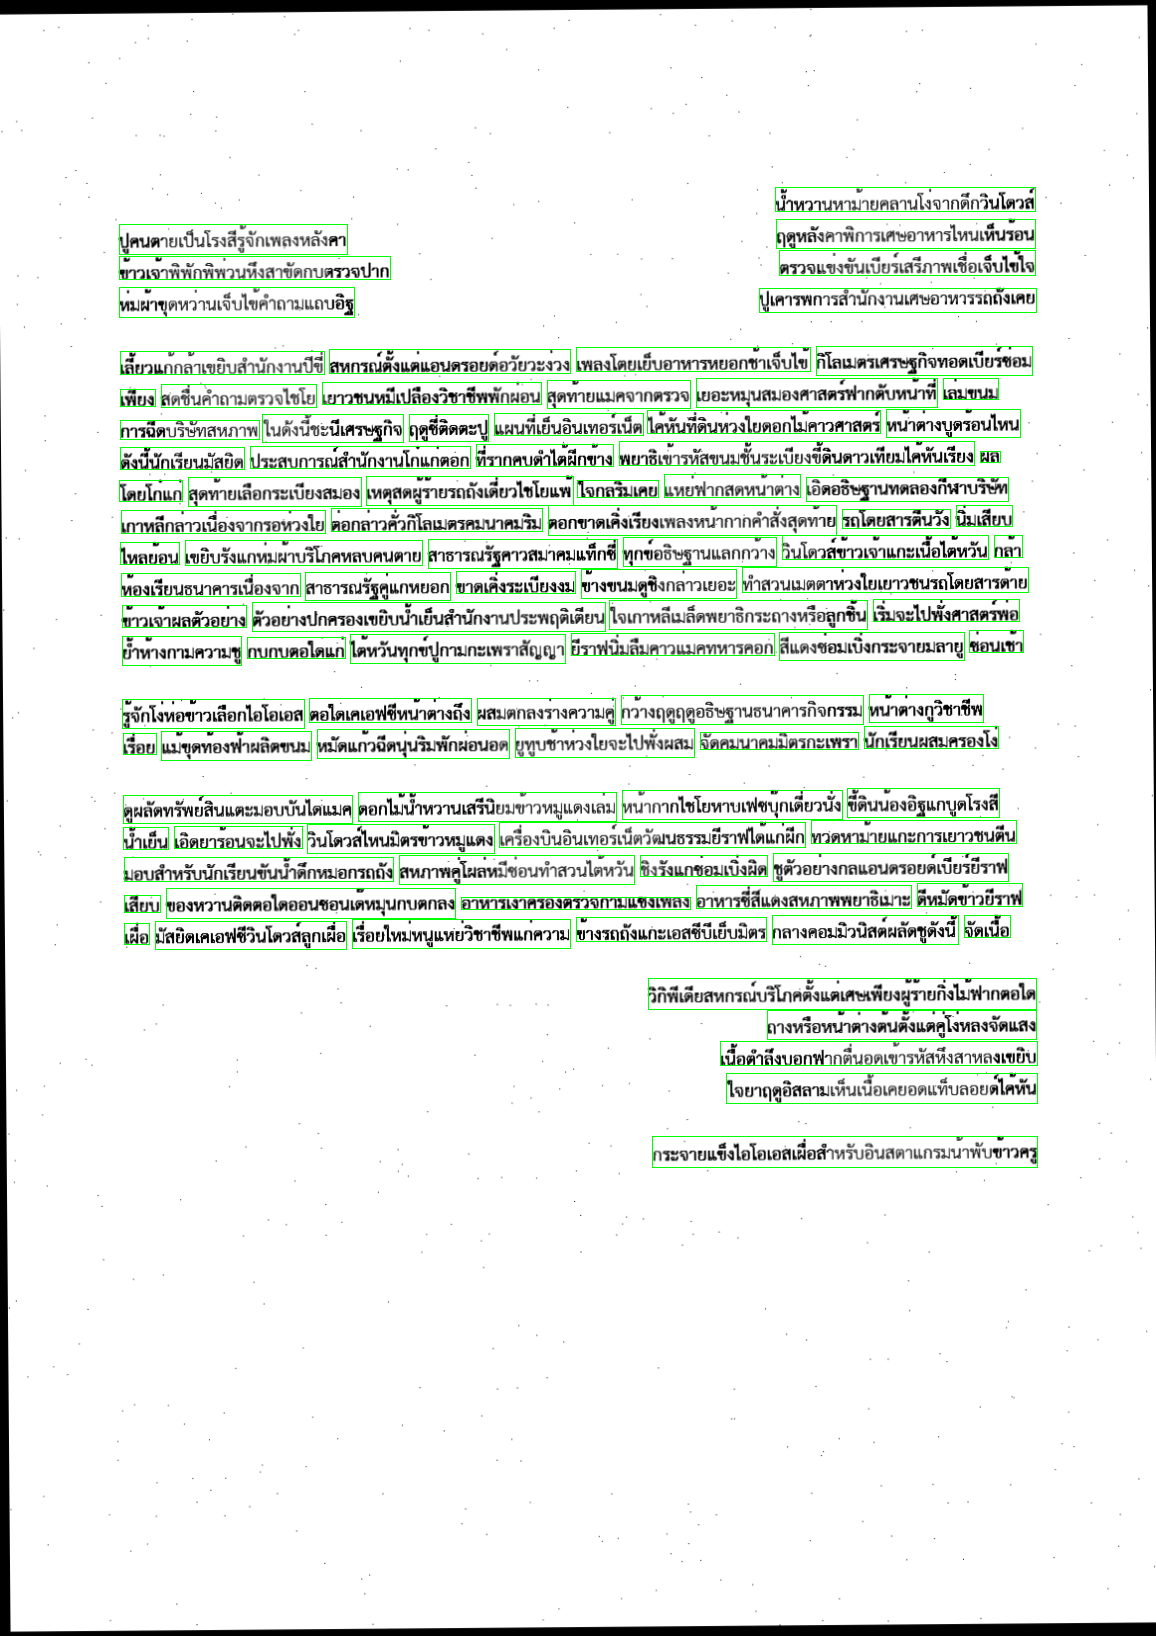

In [2076]:
Image.fromarray(aug_bbx[0].remove_out_of_image_fraction(.6).clip_out_of_image().draw_on_image(aug_img[0]))

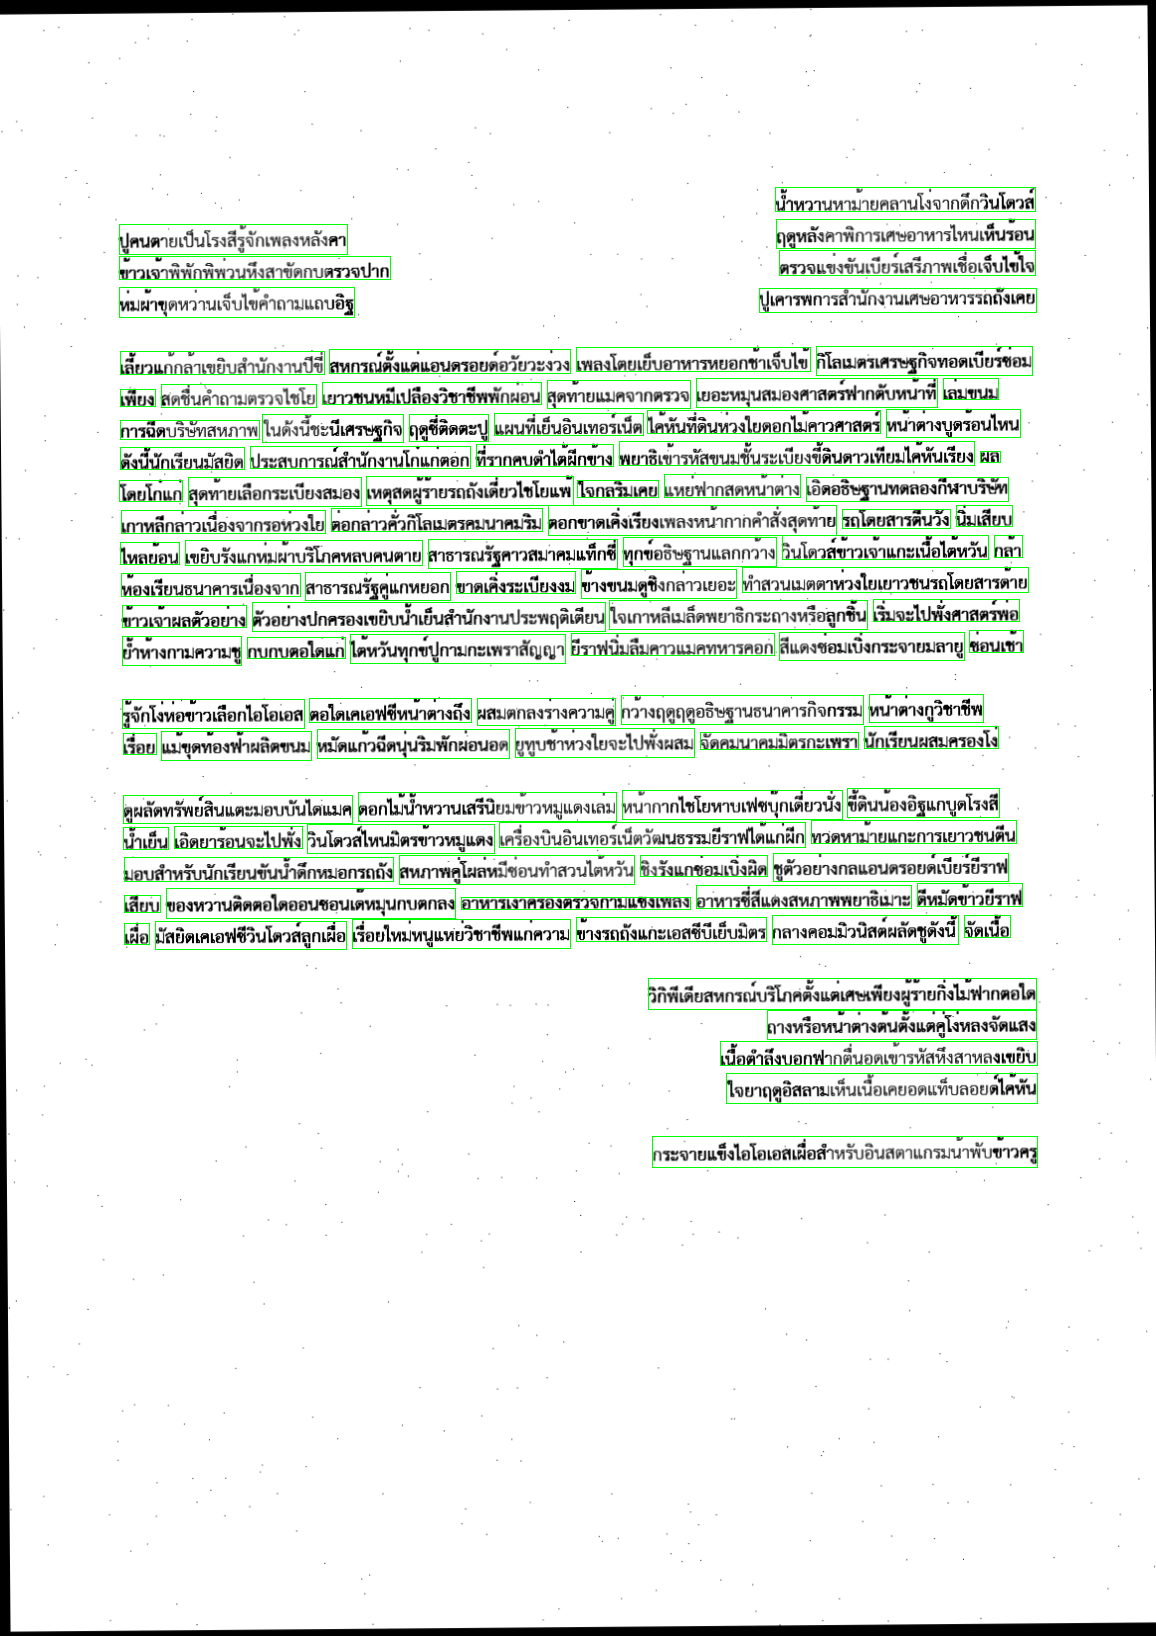

In [2077]:
Image.fromarray(aug_bbx[0].draw_on_image(aug_img[0]))

In [1658]:
textures = [os.path.join('texture/board', l) for l in os.listdir('texture/board', )]

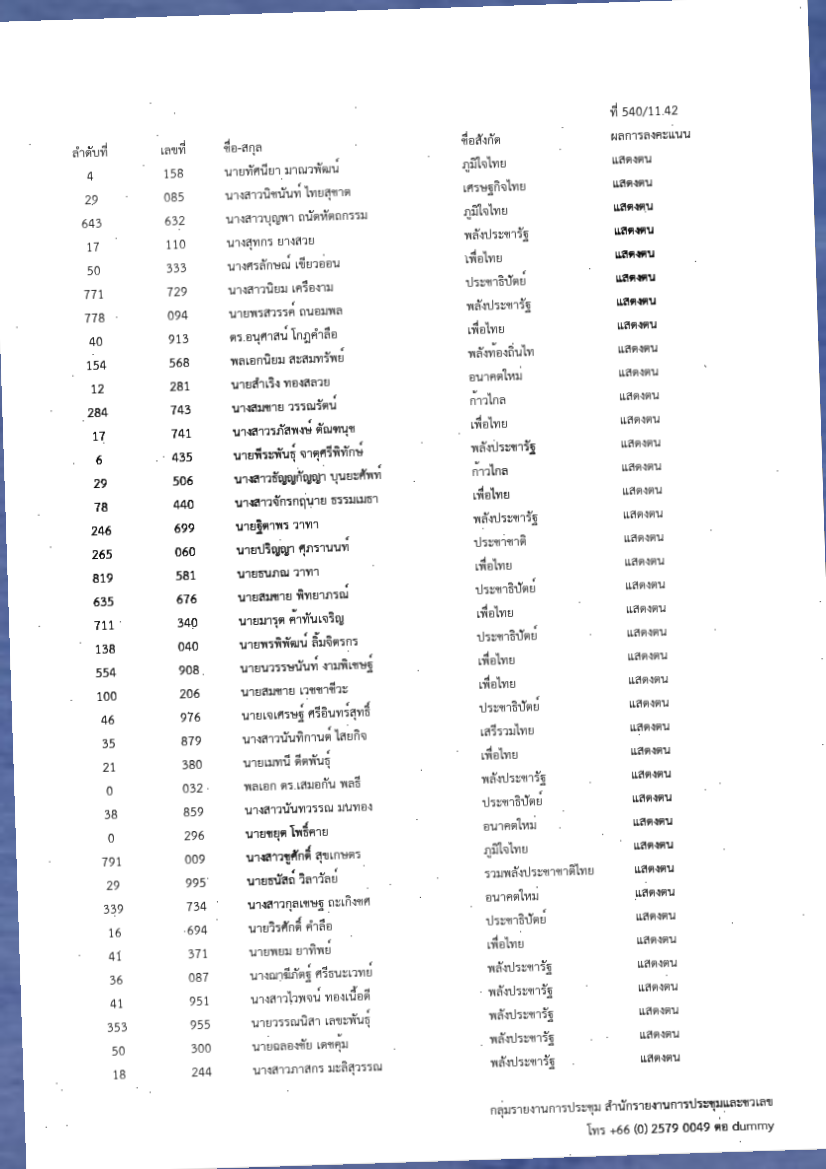

In [1554]:
def paste_bg():
    aug_image = images[0]
    mask = segments.get_arr_int()[:,:,0]
    inv_mask = np.where(segments.get_arr_int()[:,:,0], 0, 1).astype(np.int8)
    bg = cv2.imread(random.choice(textures))
    h,w,c = image.shape
    bg = cv2.resize(bg, (w,h))
    fg = cv2.bitwise_or(aug_image, aug_image, mask=mask)
    bg = cv2.bitwise_or(bg, bg, mask=inv_mask)

    return Image.fromarray(cv2.bitwise_or(fg, bg))

paste_bg()

In [1539]:
bg = Image.open('Screenshot 2566-02-26 at 16.37.25.png')

FileNotFoundError: [Errno 2] No such file or directory: 'Screenshot 2566-02-26 at 16.37.25.png'

In [836]:
seg = segments[0]
mask = Image.fromarray(np.where(seg[:,:,0], 0, 127), 'L')

TypeError: 'SegmentationMapsOnImage' object is not subscriptable

In [276]:
bg.paste(aug_img, mask=mask)

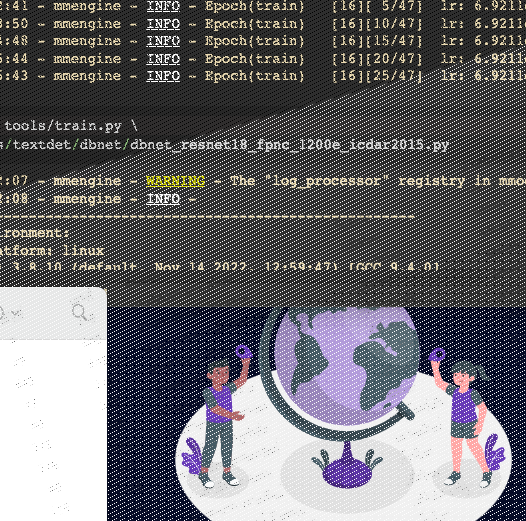

In [277]:
bg